In [4]:
# Apply Long Short-Term Memory (LSTM) networks to trian and predict for ED daily arrivals
import sklearn, keras, matplotlib
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import load_model, Model
from attention import Attention
from keras import backend
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
print('Scikit-Learn:',sklearn.__version__)
print('Keras:',keras.__version__)
print('Numpy:',np.__version__)
print('Pandas:',pd.__version__)
print('Matplotlib:',matplotlib.__version__)

Scikit-Learn: 0.23.2
Keras: 2.4.3
Numpy: 1.18.5
Pandas: 1.1.1
Matplotlib: 3.3.1


# LSTM Model Many to One
# Environment Package:
# Numpy, Keras(Tensorflow), Pandas, Matplotlib

In [9]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
# load the dataset
dataframe = read_csv('Linkou.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
dataframe.head()

,No
0,20
1,73
2,43
3,86
4,73


<AxesSubplot:xlabel='DATE'>

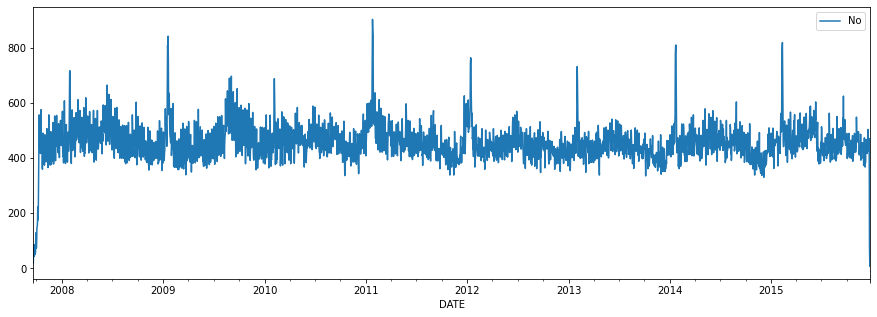

In [17]:
## plot a time series line plot.
df = pd.read_csv("Linkou.csv")

## drop the columns we don’t need, then convert “Date” column to datatime data type and set “Date” column to index
##df.drop(['temp', 'humi', 'workday', 'weekend', 'single_day', 'ch_year_low', 'ch_year_high', 'holiday_low', 'holiday_high', 'seasonal', 'temd1', 'temd2', 'temd3'], axis=1, inplace=True)
df['DATE'] = pd.to_datetime(df['DATE'])
ind_df = df.set_index(['DATE'])
ind_df.head()

#df.DATE = pd.to_datetime(df.DATE)
#df = df.set_index("DATE")
#df.head()

ind_df = ind_df.sort_index()
plt.rcParams["figure.figsize"] = (15,5)
ind_df.plot()

In [18]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset.shape

(3019, 1)

In [30]:
# split into train and test sets
test_size = 365
train_size = len(dataset) - test_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [31]:
# reshape into X=t and Y=t+1
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [32]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [9]:
# create and fit the LSTM network
#K.get_graph()
model_input = Input(shape=(1, 30))

x = LSTM(4)(model_input)

x = Dense(1)(x)
model = Model(model_input, x)
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(trainX, trainY, epochs=1000, batch_size=30, validation_data=(testX, testY), verbose=1)

0.0031
Epoch 805/1000
88/88 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 806/1000
88/88 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 807/1000
88/88 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 808/1000
88/88 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 809/1000
88/88 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 810/1000
88/88 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 811/1000
88/88 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 812/1000
88/88 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 813/1000
88/88 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 814/1000
88/88 [==============================] - 0s 5ms/step - loss:

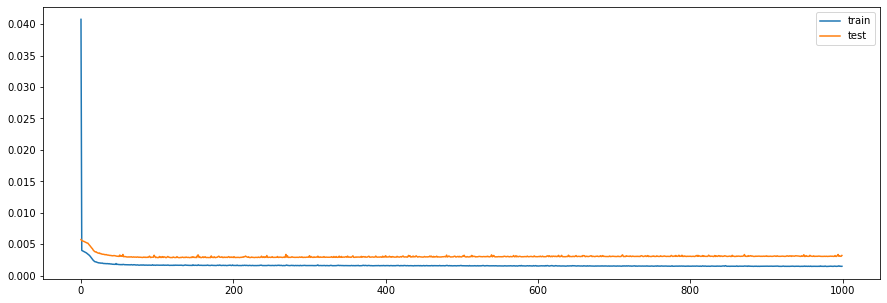

In [33]:
# plot history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [34]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [35]:
print(testX.shape)
print(testPredict.shape)
print(testY.shape)

(334, 1, 30)
(334, 1)
(334,)


In [36]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [37]:
# calculate root mean squared error
trainrmse = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainrmse))
testrmse = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testrmse))

Train RMSE: 35.51
Test RMSE: 50.66


In [38]:
# calculate MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

trainmape = mape(trainY[0], trainPredict[:,0])
print('Train MAPE: %.2f' % (trainmape))
testmape = mape(testY[0], testPredict[:,0])
print('Test MAPE: %.2f' % (testmape))

Train MAPE: 6.10
Test MAPE: 28.16


In [39]:
# calculate MAE
def mae(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)))

trainmae = mae(trainY[0], trainPredict[:,0])
print('Train MAE: %.2f' % (trainmae))
testmae = mae(testY[0], testPredict[:,0])
print('Test MAE: %.2f' % (testmae))

Train MAE: 27.19
Test MAE: 31.52


In [40]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [41]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

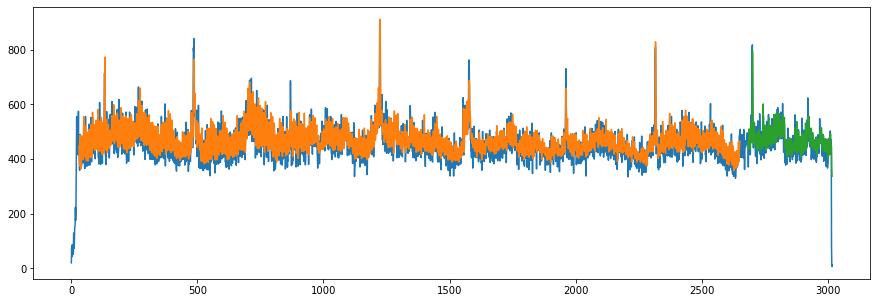

In [42]:
# plot baseline and predictions
plt.figure(figsize=(15,5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Text(0.5, 1.0, 'Green stands for true values, Red stands for predictions')

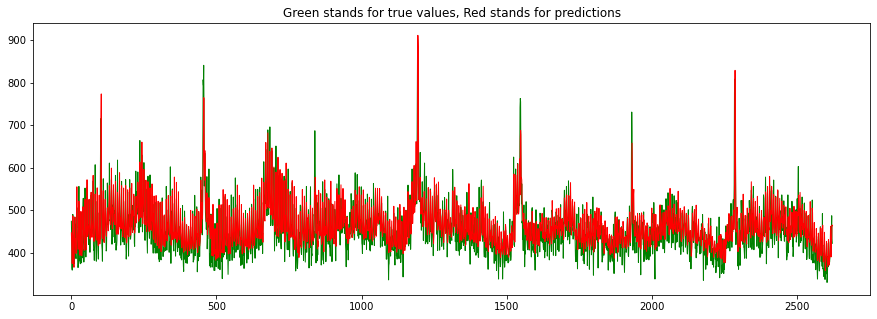

In [43]:
## plot training set for baseline and predictions
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(trainY[0])), trainY[0], linewidth=1, color='g')
plt.plot(np.arange(len(trainPredict[:,0])), trainPredict[:,0], linewidth=1, color='r')
plt.title('Green stands for true values, Red stands for predictions')

Text(0.5, 1.0, 'Green stands for true values, Blue stands for predictions')

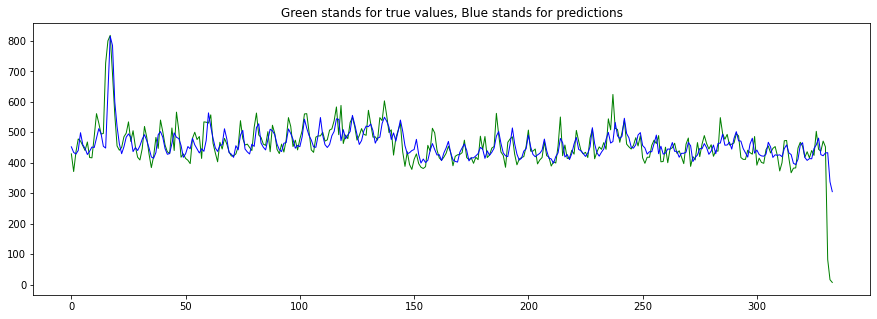

In [20]:
## plot testing set for baseline and predictions
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(testY[0])), testY[0], linewidth=1, color='g')
plt.plot(np.arange(len(testPredict[:,0])), testPredict[:,0], linewidth=1, color='b')
plt.title('Green stands for true values, Blue stands for predictions')